<a href="https://colab.research.google.com/github/juhhg/RC-Tutorial-2023/blob/main/chapter_1_ESN_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RC-Tutorial 2023

#### Main purposes of this tutorial:

- Understand the basic concepts and properties of the Echo State Network (ESN)<sup>[1]</sup>.
- Become able to implement the ESN.
- Become able to confirm properties of the ESN.

#### Contributors to this Tutorial:
Members of ISI Lab.

- Kohei Nakajima (k-nakajima@isi.imi.i.u-tokyo.ac.jp)
- Nozomi Akashi (Contributed to the first version. OB of ISI Lab.)
- Quoc Hoan Tran (Contributed to the second version. OB of ISI Lab)
- Katsuma Inoue   (k-inoue@isi.imi.i.u-tokyo.ac.jp)
- Katsushi Kagaya (kagaya@isi.imi.i.u-tokyo.ac.jp)
- Tomoyuki Kubota (kubota@isi.imi.i.u-tokyo.ac.jp)
- TA: Wentao Sun (sun@isi.imi.i.u-tokyo.ac.jp)
- TA: Ryo Terajima (terajima@isi.imi.i.u-tokyo.ac.jp)

#### Programming Language and Environment
- Python
 - In the tutorial, we use Python for the demonstrated codes. However, you can use any language that you are familiar with for your implementation.
- Google Colaboratory
- Please prepare your Google account


## Local Environment
- If you use the jupyter notebooks in your local environment, you can use [Anaconda](https://www.anaconda.com/products/distribution), a cross-platform Python distribution for scientific computing. Jupyter, included in Anaconda, is recommended for interacting with RC tutorial.
- Of course, you can install the needed packages via "<b>pip install</b>" without using Anaconda.
- We recommend using Python virtual environments to cleanly separate RC Tutorial from other applications and improve your experience.

The simplest way to use environments is by using the <b>conda</b> command, included with Anaconda. A Conda environment allows you to specify a specific version of Python and a set of libraries.

Open a terminal window in the directory where you want to work. It is preferred that you use the Anaconda prompt installed with Anaconda. All you have to do is create a virtual environment inside Anaconda and activate the environment.

These commands can be run in the Anaconda prompt irrespective of Windows or Linux machine.

#### Install

Create a minimal environment with only Python installed in it.

>       conda create -n ENV_NAME python=3

Activate your new environment

>       conda activate ENV_NAME

Next, install some useful packages for this tutorial. We recommend numpy for scientific library and matplotlib for displaying plots.

>       conda install -n ENV_NAME ipykernel notebook numpy scipy networkx matplotlib --update-deps --force-reinstall

#### Editors

You can use any python editors (Visual Studio Code,Sublime Text, Atom, etc)  intergrated with jupyter notebook to view this notebook. The easiest way to do is to use your browser. Use Conda terminal to locate this Notebook's folder and run:

>      \Workspace\RC-Tutorial\notebooks>jupyter notebook


## Chapter I: Standard Setting of Echo State Network


In this chapter, we present the standard setting and basic implementation for Echo State Network (ESN).

ESN is the concept proposed by Jaeger<sup>[1]</sup>(2001).  It belongs to the concept of Recurrent Neural Network (RNN) as we have a large network (= <b>reservoir</b>) with randomly fixed inner and recurrent connections. However, we do not use a tricky method like Backpropagation to train the recurrent connection.

<center>
    <img src="https://drive.google.com/uc?export=view&id=1ARZbx-mYv3irOVfb0ajET7RDHQJ5GjZa" style="width:650px;height:200px;">
    <figcaption align = "center"><b>Fig.1 Feed forward (left) and recurrent (right) neural networks <sup>[2]</sup> </b></figcaption>
</center>

The input is put sequentially inside the reservoir at every timestep, where the inner state is updated via the recurrent relation. We can achieve a wide class of nonlinear processing for input sequence with this setting by simply learning or adjusting only the outer readout. The key idea is the high dimensionality, and the input record is memorized inside the reservoir.

#### Key idea of ESN
- Use activation function for nonlinearity (same as RNN)
- Use (randomly) <b>fixed</b> the recurrent connection weights for high dimensionality
- Simply <b>training the outer readout</b> (low training cost vs. Backpropagation in RNN)
- <b>Multitasking</b> (use different readouts for different tasks, particullary useful to save the resources)

<center>
    <img src="https://drive.google.com/uc?export=view&id=1KBWK4L5tGNAkqL9lgCOV4rCG0CwfIDQL" style="width:750px;height:300px;">
<figcaption align = "center"><b>Fig.2 (Left) Basic structure of ESN. (Right) An example of PRC platform with a silicone-based soft robotic arm inspired by the octopus. <sup>[3]</sup> </b></figcaption>
</center>

In principle, any large-degree-of-freedom dynamical system that actually has nonlinearity can be used as a candidate for a physical implementation of the reservoir. These implementations are studied in the field of Physical Reservoir Computing (PRC)<sup>[3]</sup>. For example, the movement of an octopus foot on the water surface can be picked up from a sensor as a computational resource, and a complex nonlinear time series can be processed by simply linearly combining the sensor values.

### Procedures for temporal ML tasks using ESN

1. Prepare time-series input/output data
2. Select the type of ESN model
3. Design the selected model (hyper fixed parameters)
4. Select a learning algorithm and optimize the readout
5. Evaluate the training and validation (generalization) errors


### Temporal machine learning (ML) tasks using ESN
- Discrete time $t\in\mathbb{Z}$
- Input $u(t)$
- Generated reservoir states $\boldsymbol{x}(t)$ with readout function $\mathcal{R}$
- Target output $y(t)$ generated by input sequence $\{u(1), u(2), \ldots, u(t)\}$
- We aim to approximate the target $y(t)$ via $\hat{y}(t)=\mathcal{R}(\boldsymbol{x}(t))\approx y(t) $
- [The key idea is under some suitable conditions, $\boldsymbol{x}(t) = \boldsymbol{\psi}(u(t), u(t-1),\ldots)$ is an input echo function (Chapter III, V)].

### Typical formulation of the ESN

#### Input layer
- One-dimensional input: $u_t$
- Input weight (fixed):  
$$W_{in} =
\begin{bmatrix}
w^{\rm in}_{1} \cdots w^{\rm in}_{N}
\end{bmatrix}^\top \in \mathbb{R}^{N}$$

- Input weights are often randomly generated via uniform distribution with $w^{\rm in}_{i} \in [-\sigma, \sigma]$ with $\sigma$ is called <b>input-scale</b> coefficient.

#### Reservoir layer
- Internal units (reservoir states): $\boldsymbol{x}_t = [x_{1,t}\ldots x_{N,t}]^\top \in \mathbb{R}^{N}$
- Internal weight (fixed):
$$W = \begin{bmatrix}
    w_{1,1} & \cdots & w_{1,N} \\
    \vdots & \ddots & \vdots \\
    w_{N,1} & \cdots & w_{N,N}
\end{bmatrix} \in \mathbb{R}^{N}\times \mathbb{R}^{N}$$

- $W$ is often controlled by the <b>spectral radius</b> $\rho(W)$, which is the maximum absolute value of the eigenvalue of $W$ (more detailed in Chapter II and III)


#### Output layer (for a single task)
- Output units: $\hat{y}_t \in \mathbb{R}$
- Output weight (need to train):  
$$W_\rm{out} =
\begin{bmatrix}
    w^\rm{out}_{0} & w^\rm{out}_{1} &\cdots & w^\rm{out}_{N}
\end{bmatrix}^\top
\in \mathbb{R}^{N + 1}$$

### Time evolution of the ESN
- Input units: $u_t$
- Internal units:
$$
\boldsymbol{x}_{t+1} = f(W\boldsymbol{x}_t + W_{\rm in} u_t)
$$
 with activation function e.g., $f(\boldsymbol{x})=[{\rm tanh}(x_1) \cdots {\rm tanh}(x_N)]^\top$
- Output units:
\begin{align}
\hat{y}_{t} &= W_{\rm out}[\boldsymbol{1}: \boldsymbol{x}_{t}] \\
&= W_{\rm out}{[1 \quad x_1 \quad \cdots \quad x_{N}]}^\top \\
&= w^{\rm out}_0 + \sum_{i=1}^{N} w^{\rm out}_i x_{i,t}
\end{align}
 (The reservoir state is added with bias 1 for the optimziation)

### Some variations
- ESN with feedback
$
\boldsymbol{x}_{t+1} = f(W\boldsymbol{x}_{t} + W_{\rm in}u_{t} + W_{fb}\hat{\boldsymbol{y}}_t)
$

- Leaky (Integrator) ESN with <b>leaky rate</b> (or <b>retain rate</b>) to control the scale of dynamics
\begin{align}
\boldsymbol{x}_{t+1} = (1-\alpha)\boldsymbol{x}_{t} + \alpha~{\bf \tanh}(W\boldsymbol{x}_{t} + W_{\rm in}u_{t})
\end{align}


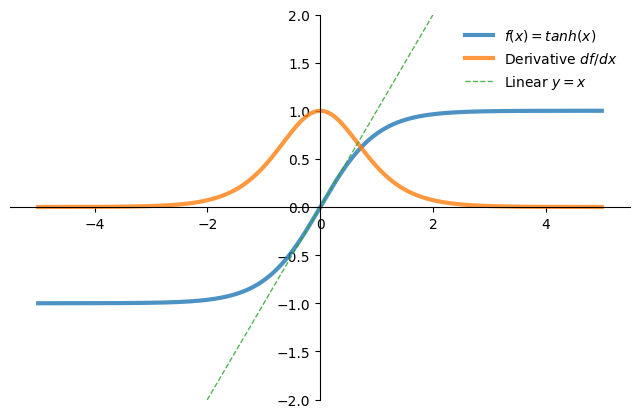

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tanh(x):
    epx = np.exp(x)
    eivx = np.exp(-x)
    return (epx - eivx)/ (epx + eivx)

x = np.arange(-5., 5., 0.01)
f = tanh(x)
dfdx = 1 - f**2

fig, ax = plt.subplots(figsize=(8,5))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(x,f, linewidth=3, label=r"$f(x)=tanh(x)$", alpha=0.8)
ax.plot(x,dfdx, linewidth=3, label=r"Derivative $df/dx$", alpha=0.8)
ax.plot(x,x, linewidth=1, label=r"Linear $y=x$", alpha=0.8,ls='--')
ax.set_ylim(-2,2)
ax.legend(loc="upper right", frameon=False)

### Implement the basic structure of ESN

First, let's build an echo state network and solve a typical bechmark task called the NARMA10.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# The number of nodes
N = 50
# Washout time
Two = 100
# Total timestep (training + evaluation phase)
Ttrain = 2000
Teval = 1000
T = Ttrain + Teval

# Input following the uniform distribution in the range of [-1,1]
np.random.seed(2)
u = np.random.uniform(-1,1,Two+T)
print('u',u,u.shape,'min',u.min(),'max',u.max())

# Input weight [-sigma,sigma]
sigma = 0.1
np.random.seed(1)
Win = np.random.uniform(-sigma,sigma,N)
print('Win',Win,Win.shape)

# Internal weight matrix
rho = 0.9
np.random.seed(0)
W = np.random.uniform(-1,1,(N,N))
eigs = np.linalg.eigvals(W)
W = rho*W/np.max(np.abs(eigs))
print('W',W.shape)
print('Eigenvalues',np.abs(np.linalg.eigvals(W)))

u [-0.1280102  -0.94814754  0.09932496 ... -0.9090184   0.16696934
 -0.14130116] (3100,) min -0.9981963676204246 max 0.9983414729348652
Win [-0.0165956   0.0440649  -0.09997713 -0.03953349 -0.07064882 -0.08153228
 -0.06274796 -0.03088785 -0.02064651  0.00776335 -0.0161611   0.0370439
 -0.05910955  0.07562349 -0.09452248  0.0340935  -0.01653904  0.01173797
 -0.07192261 -0.0603797   0.06014891  0.09365232 -0.03731516  0.03846452
  0.07527783  0.07892133 -0.08299116 -0.09218904 -0.06603392  0.0756285
 -0.08033063 -0.01577847  0.09157791  0.00663306  0.03837542 -0.03689687
  0.03730019  0.06692513 -0.09634234  0.05002886  0.09777222  0.04963313
 -0.0439112   0.05785587 -0.0793548  -0.01042129  0.0817191  -0.04127717
 -0.04244493 -0.07399429] (50,)
W (50, 50)
Eigenvalues [0.9        0.85855897 0.80655682 0.80655682 0.71587447 0.71587447
 0.73869111 0.73869111 0.68003024 0.68003024 0.63188007 0.63188007
 0.68489007 0.68489007 0.73831565 0.73831565 0.70688119 0.70688119
 0.66149011 0.66149011

In [ ]:
X = np.ones((Two+T,N))
for t in range(1,Two+T):
    X[t] = np.tanh(W @ X[t-1] + Win*u[t-1])
print('X',X,X.shape)
print(np.linalg.matrix_rank(X[Two:].T @ X[Two:]))


X [[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 0.63388375 -0.94886159  0.93382634 ... -0.52046715 -0.55831318
   0.23182873]
 [ 0.18417517 -0.43774866  0.01234705 ... -0.27280241  0.79463297
  -0.29004221]
 ...
 [-0.05275834 -0.00340795 -0.04938779 ... -0.04822713  0.0325653
  -0.02359478]
 [ 0.01414883 -0.03815341  0.09660327 ...  0.0492594   0.05970486
   0.04393959]
 [-0.01079438 -0.03480714  0.09090808 ...  0.03109678 -0.0405255
  -0.00353001]] (3100, 50)
50


### Washout Phase
- To make time-series stationary, we discard initial timesteps from time series
- Total washout timestep $T_{\rm washout}$
- Input sequence $\{u_{1-T_{\rm washout}}\cdots u_0\}$, whose length $=0-(1-T_{\rm washout})+1=T_{\rm washout}$.
- (A mathematical perspective is expained in Chapter V)

Text(0.5, 0.92, 'Training and evaluation phases ($t=1,\\ldots,T_{\\rm train}+T_{\\rm eval}$)')

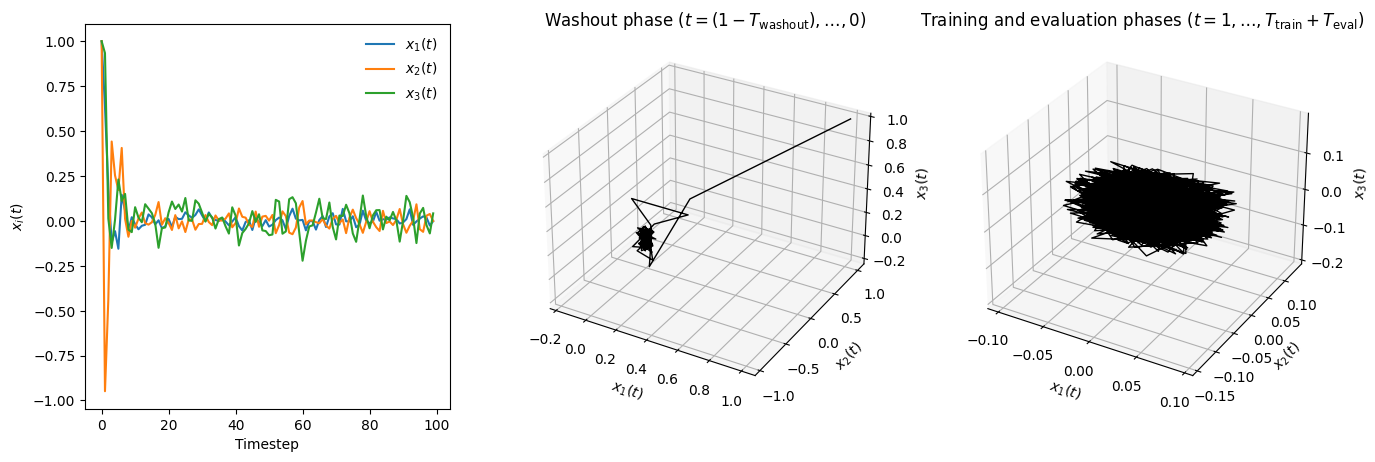

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(131)
ax.plot(X[:Two,0],label=r'$x_1(t)$')
ax.plot(X[:Two,1],label=r'$x_2(t)$')
ax.plot(X[:Two,2],label=r'$x_3(t)$')
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$x_{i}(t)$')
ax.legend(loc="upper right", frameon=False)

ax = fig.add_subplot(132, projection='3d')
ax.plot(X[:Two,0], X[:Two,1], X[:Two,2], color="black",linewidth=1)
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_title(r'Washout phase ($t=(1-T_{\rm washout}),\ldots,0$)')

ax = fig.add_subplot(133, projection='3d')
ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="black",linewidth=1)
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_title(r'Training and evaluation phases ($t=1,\ldots,T_{\rm train}+T_{\rm eval}$)')


### Training of the ESN

- Total training timestep $T_\rm{train}$
- Input sequence: $\{u_1, \ldots, u_{T_\rm{train}}\}$
- Consider the situation of solving a single task.
- Target sequence $\{y_{1},\ldots,y_{T_\rm{train}}\}$
- The task should approximate $\hat{y}_{t} \approx y_{t}$ by minimizing

$$
{\rm Err} = \sum_{t=1}^{T_{\rm train}} \Vert  y_t - \hat{y}_t \Vert^2
$$

The training can be performed by <b>Offline Training</b> or <b>Online Training</b> (see Chap. VI)

#### Training Readout Weight by (Offline) Linear Regression

- In the offline training, we firstly collect all time-series data and then divide them into three parts:  data used for the washout, training, and evaluation phases.
- (Extended) Reservoir state matrix
$$
\boldsymbol{X}_{\rm train} =
\begin{bmatrix} 1 & x_{1,1} &\cdots & x_{N,1} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{1,T_{\rm train}} & \cdots & x_{N,T_{\rm train}}  
\end{bmatrix} \in \mathbb{R}^{T_{\rm train}}\times \mathbb{R}^{N + 1}
$$

- Target output vector:
$$
\boldsymbol{y}_{\rm train} = [y_{1} \cdots y_{T_{\rm train}}]^\top \in \mathbb{R}^{T_{\rm train}}
$$
- Output weight to train the output:
$$\boldsymbol{w}^{\rm out} = [{w}^{\rm out}_{0} \quad {w}^{\rm out}_{1} \quad \cdots \quad {w}^{\rm out}_{N} ]^\top \in \mathbb{R}^{N+1}$$

- We rewrite the training error as
$$
{\rm Err} = \sum_t \Vert y_t - \hat{y}_t \Vert^2 =  \sum_t \Vert y_t - [1: \boldsymbol{x}_t]\boldsymbol{w}^{\rm out} \Vert^2 = \Vert \boldsymbol{y}_{\rm train} - \boldsymbol{X}_{\rm train}\boldsymbol{w}^{\rm out} \Vert^2
$$
- If $\boldsymbol{X}_{\rm train}^\top\boldsymbol{X}_{\rm train}$ is full rank, we minimize ${\rm Err}$ to obtain
$$
\hat{\boldsymbol{w}}^{\rm out} = \arg \min_{\boldsymbol{w}^{\rm out}}{\rm Err} = (\boldsymbol{X}_{\rm train}^\top\boldsymbol{X}_{\rm train})^{-1}\boldsymbol{X}_{\rm train}^\top \boldsymbol{y}_{\rm train},
$$
where $\boldsymbol{X}^{+}_{\rm train} = (\boldsymbol{X}_{\rm train}^\top\boldsymbol{X}_{\rm train})^{-1}\boldsymbol{X}_{\rm train}^\top$ is called the (Moore-Penrose) pseudo-inverse matrix.
- Finally, the output is described by
$$
\hat{y}_t = [1:\boldsymbol{x}_t]\hat{\boldsymbol{w}}^{\rm out}~(t=1+T_{\rm train},\ldots,T_{\rm train}+T_{\rm eval})
$$
or
$$
\hat{\boldsymbol{y}} = \boldsymbol{X}_{\rm eval}\hat{\boldsymbol{w}}^{\rm out},
$$
where
$$
\boldsymbol{X}_{\rm eval} =
\begin{bmatrix} 1 & x_{1,T_{\rm train}+1} &\cdots & x_{N,T_{\rm train}+1} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{1,T_{\rm train}+T_{\rm eval}} & \cdots & x_{N,T_{\rm train}+T_{\rm eval}}  
\end{bmatrix} \in \mathbb{R}^{T_{\rm eval}}\times \mathbb{R}^{N + 1}.
$$


### NARMA10―The 10th-order Nonlinear Autogressive Moving Average<sup>[4]</sup>

NARMA10<sup>[4]</sup> is a typical benchmark task in RC. It is a type of nonlinear ARMA model consisting of an autoregressive part and a moving average part, with nonlinear dependence between current and past values.
Given a uniformly random input $u(t)\in[-1,1]$ that is injected to the ESN, the NARMA10 model is defined as

$$
y(t+1) = \alpha y(t) + \beta y(t)\sum_{i=0}^{9}y(t-i) + \gamma v(t-9)v(t) + \delta,
$$
$$
v(t)=0.5\frac{u(t)+1}{2}
$$
where $(\alpha,\beta,\gamma,\delta)=(0.3,0.05,1.5,0.1)$, and
the input $u(t)$ is carefully biased and scaled to $v(t) \in [0.0, 0.5]$ to avoid diverging in the model.

v 0.00045090809489384265 0.4995853682337163
[0.         0.         0.         ... 0.43802611 0.32423444 0.44826811] (3100,)


Text(0, 0.5, '$y(t)$')

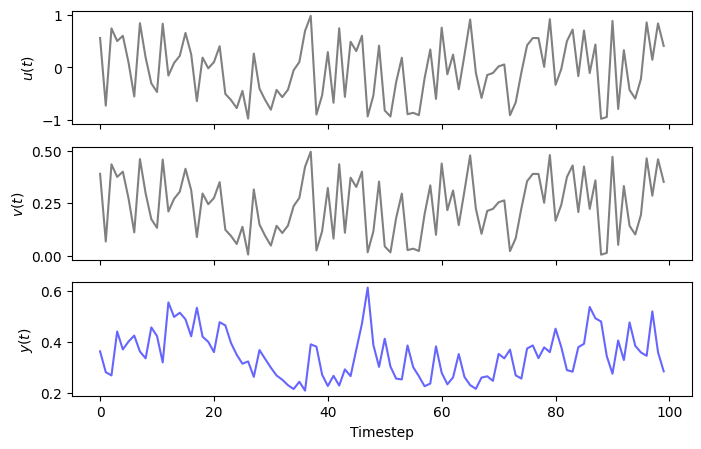

In [ ]:
# Input u in [-1,1] is biased and scaled to v in [0.0,0.5]
v = 0.25*(u+1)
print('v',v.min(),v.max())

# Run NARMA10
a,b,c,d = 0.3,0.05,1.5,0.1
y = np.zeros(Two+T)
for t in range(10,Two+T):
    y[t] = a * y[t-1] + b * y[t-1] * (np.sum(y[t-10:t])) + c * v[t-10] * v[t-1] + d
print(y,y.shape)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(311)
ax.plot(u[Two:Two+100],color='gray')
ax.set_xticklabels([])
ax.set_yticks([-1,0,1])
ax.set_ylabel(r'$u(t)$')

ax = fig.add_subplot(312)
ax.plot(v[Two:Two+100],color='gray')
ax.set_xticklabels([])
ax.set_yticks([0.0,0.25,0.5])
ax.set_ylabel(r'$v(t)$')

ax = fig.add_subplot(313)
ax.plot(y[Two:Two+100],color='blue',alpha=0.6)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$y(t)$')


### Practice
1. Check that a NARMA10 model with the input $v(t)\in[0,1]$ diverges.
2. Check that the NARMA10 model with $v(t)\in[0,0.5]$ also diverges if the total time length is very long (e.g., $T=10^6$).

In [ ]:
# 1.

In [ ]:
# 2.

### Solve the NARMA10 task using the ESN

X (after washout) (3000, 51) y (after washout) (3000, 1)


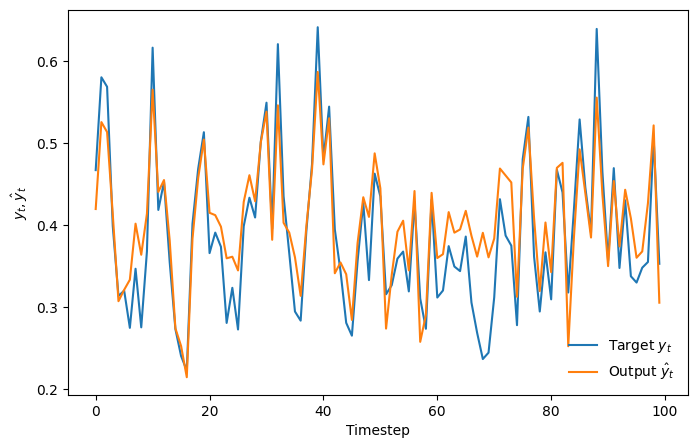

In [ ]:
# Discard the initial steps from the state and add a bias term
Xwo = np.hstack([X[Two:],np.ones((T,1))])
# Discard the initial steps from the target
ywo = y[Two:].reshape((T,1))
print('X (after washout)',Xwo.shape,'y (after washout)',ywo.shape)
# Split time-series into training and evaluation phases
Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]

# Calculate wout estimate with a pseudo inverse matrix
wout = np.linalg.pinv(Xtrain) @ ytrain
# Calculate output
yhat = Xeval @ wout

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(yeval[:100,0],label=r'Target $y_t$')
ax.plot(yhat[:100,0],label=r'Output $\hat{y}_t$')
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$y_t, \hat{y}_t$')
ax.legend(loc='lower right',frameon=False)

### How to evaluate the performance
- Total evaluation timestep $T_{\rm eval}$
- Root mean squared error (RMSE)
$$
{\rm RMSE} =  \sqrt{\dfrac{1}{T_{\rm eval}} {\rm Err}} = \sqrt{ \dfrac{1}{T_{\rm eval}} \sum_{t=T_{\rm train}+1}^{T_{\rm train}+T_{\rm eval}} ( y_t - \hat{y}_t)^2}
$$

- Normalized root mean squared error (NRMSE) to deal with scale/magnitude of the output

$$
{\rm NRMSE} = \dfrac{1}{\sigma(\boldsymbol{y}_{\rm eval})} {\rm RMSE},
$$
where $\sigma^2(\boldsymbol{y}_{\rm eval})$ is the variance of $\boldsymbol{y}_{\rm eval}=\{y_{T_{\rm train}+1} \cdots y_{T_{\rm train}+T_{\rm eval}} \}$ through time.

- ${\rm NRMSE} < 0.2$ is an indicator for a good performance.

In [ ]:
# Evaluate
MSE = np.mean((yhat - yeval) ** 2)
RMSE  = np.sqrt(MSE)
NRMSE = RMSE/np.std(yeval)
print('MSE',MSE,'RMSE',RMSE,'NRMSE',NRMSE)


MSE 0.0017430585839029766 RMSE 0.041749953100608105 NRMSE 0.40165464571974185


### Summarize the Codes
To use the above codes repeatedly and easily, we here make a function and class.

Target [0.         0.         0.         ... 0.44008548 0.5650828  0.47017151] (3100,)


Text(0, 0.5, '$y(t)$')

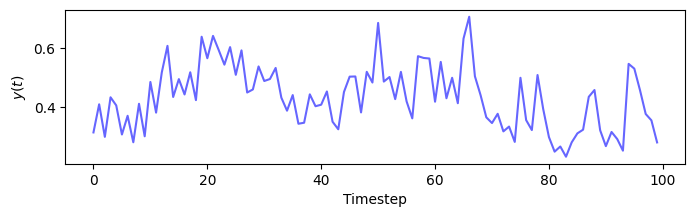

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function of the NARMA10 model
def narma10(v,a=0.3,b=0.05,c=1.5,d=0.1):
    T = len(v)
    y = np.zeros(T)
    for t in range(10,T):
        y[t] = a * y[t-1] + b * y[t-1] * (np.sum(y[t-10:t])) + c * v[t-10] * v[t-1] + d
    return y

# We define the input manually
Two,Ttrain,Teval = 100,2000,1000
T = Ttrain + Teval
np.random.seed(0)
u = np.random.uniform(-1,1,Two+T) # u in [-1,1]
v = 0.25*(u+1) # v in [0.0,0.5]

# We can call this function as follows:
y = narma10(v)
print('Target',y,y.shape)

# Please compare the following figure with the above one
plt.figure(figsize=(8,2))
plt.plot(y[Two:Two+100],color='blue',alpha=0.6)
plt.xlabel('Timestep')
plt.ylabel(r'$y(t)$')

NRMSE 0.4016546457197417


Text(0, 0.5, '$y(t),\\hat{y}(t)$')

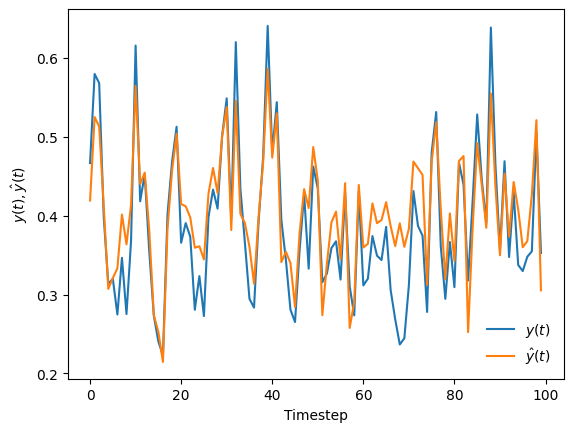

In [ ]:
# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh):
        T = len(u)
        X = np.ones((T,self.N))
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

    def washout(self,X,y,Two):
        T = X.shape[0]-Two
        Xwo = np.hstack([X[Two:],np.ones((T,1))])
        ywo = y[Two:].reshape((T,1))
        return Xwo,ywo

    def linear_regression(self,Xwo,ywo,Ttrain):
        # Split time-series into training and evaluation phases
        Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
        ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]
        # Calculate wout and output
        wout = np.linalg.pinv(Xtrain) @ ytrain
        yhat = Xeval @ wout
        # NRMSE
        NRMSE = np.sqrt(np.mean((yhat - yeval) ** 2))/np.std(yeval)
        return yeval,yhat,NRMSE

# Define parameters again
N = 50
rho = 0.9
sigma = 0.1
p,pin = 1,1

# Make an instance
esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u)
Xwo,ywo = esn.washout(X,y,Two)
yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
print('NRMSE',NRMSE)

# Please verify the results by comparing them with the previous figure
plt.figure()
plt.plot(yeval[:100],label=r'$y(t)$')
plt.plot(yhat[:100],label=r'$\hat{y}(t)$')
plt.legend(loc='lower right',frameon=False)
plt.xlabel('Timestep')
plt.ylabel(r'$y(t),\hat{y}(t)$')

### Preparation for Chapter II - Homework
The performance of NARMA10 task depends on the following important parameters:
- The number of nodes $N$
- Spectral radius $\rho$
- Input ranges of ESN and NARMA10 model (composed of input biases and scales)
- Training data length $T_{\rm train}$

Let's try to use the defined function and class and solve the NARMA10 task using the ESN with different parameters.

Homework:
1. Solve the NARMA10 with $v(t)\in[0,0.5]$ using the ESN with $(N,\rho,\sigma,T_{\rm train})=(100,0.9,0.1,2000)$ that receives an asymmetric input $u(t)\in[0,1]$ instead of the symmetric $u(t)\in[-1,1]$.
2. Using the same setting with practice 1, illustrate the relationship between $N(=100,200,\ldots,1000)$ and NRMSE.
3. Using the same setting with practice 1 but for $T_{\rm train}=10000$, illustrate the relationship between $N(=100,200,\ldots,1000)$ and NRMSE.
4. Solve the NARMA10 with $v(t)\in[-0.5,0.5]$ using the ESN with the symmetric input $u(t)\in[-1,1]$.


In [ ]:
# 1.

In [ ]:
# 2.

Target [0.         0.         0.         ... 0.53575663 0.60568582 0.46801914] (11100,)
NRMSE 0.27913628454887157
NRMSE 0.20331454659355513
NRMSE 0.16251923381787642
NRMSE 0.12419941517886224
NRMSE 0.11974003927789284
NRMSE 0.11024618876056727
NRMSE 0.08115045533881604
NRMSE 0.08494767877841959
NRMSE 0.0962466039029185
NRMSE 0.0911756274518287


Text(0, 0.5, 'NRMSE')

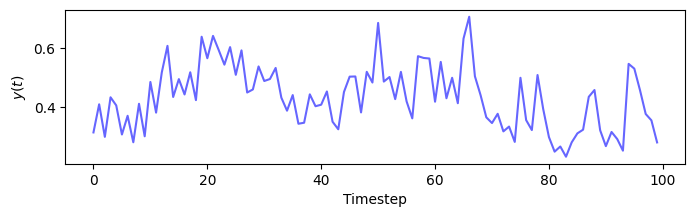

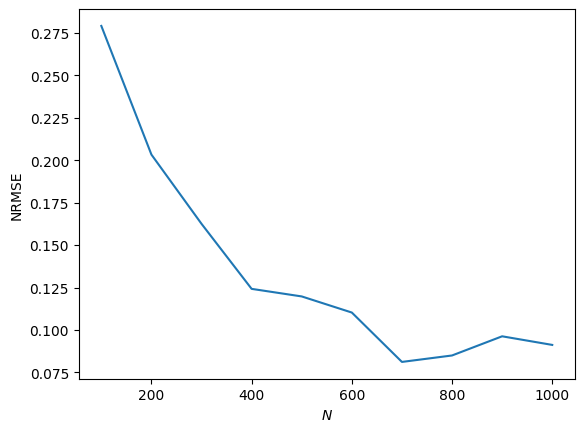

In [ ]:
# 3.

In [ ]:
# 4.


## References

[1] H. Jaeger, <em>The “echo state” approach to analysing and training recurrent neural networks-with an erratum note</em>, Bonn Germany: German National Research Center for Information Technology GMD Technical Report, 148(34), 13 (2001)

[2] H. Jaeger, <em>Tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the "echo state network" approach</em>, Bonn: GMD-Forschungszentrum Informationstechnik (2002)

[3] K. Nakajima, <em>Physical reservoir computing---an introductory perspective</em>, Japanese Journal of Applied Physics 59: 060501 (2020)

[4] A. F. Atiya, A. G. Parlos, <em>New results on recurrent network training: unifying the algorithms and accelerating convergence</em>, IEEE Transactions on Neural Networks, 11.3, 697-709 (2000)